# 02_SECOM_EDA.ipynb

이 노트북은 `secom_master_eda.csv`를 기반으로 **탐색적 데이터 분석(EDA)**을 수행한다.  
분석 범위는 다음과 같다:

- Core(1~8) 필수 EDA:
  1. 결측치 패턴 확인
  2. 상수형/저분산 피처 탐색
  3. 다중공선성 확인 (Heatmap + VIF)
  4. 불량 vs 정상 분포 차이
  5. 피처 중요도 (Logistic / RandomForest)
  6. 차원 축소 시각화 (PCA, t-SNE)
  7. 불균형 구조 확인
  8. 이상치 탐색 (Z-score, IQR)

분석 결과는 이후 전처리/모델링 방향성 수립에 활용된다.

### 공통 세팅 & 데이터 로드

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
EDA_CSV = PROJECT_ROOT / "data" / "secom_master_eda.csv"

df = pd.read_csv(EDA_CSV, parse_dates=["timestamp"])
print("Shape:", df.shape)
df.head(2)

Shape: (1567, 592)


,sensor_001,sensor_002,sensor_003,sensor_004,sensor_005,sensor_006,sensor_007,sensor_008,sensor_009,sensor_010,...,sensor_583,sensor_584,sensor_585,sensor_586,sensor_587,sensor_588,sensor_589,sensor_590,timestamp,label
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,2008-07-19 11:55:00,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.006,208.2045,2008-07-19 12:32:00,-1


## 전체 센서(590개) 통계 요약
- EDA Core(1~8)은 대표 센서를 발췌해 시각화
- 하지만 전체 590개 센서에 대한 전반적 구조를 확인하기 위해 통계 요약 추가

- 결과
1. 결측치(NaN) 분포
	- 대부분 센서(500개 이상)는 결측치가 거의 없음 (NaN 비율 ≈ 0).
	- 그러나 일부 센서는 20%~80% 이상 결측치가 존재 → 특정 구간에 결측치가 몰려 있는 센서도 확인됨.
👉 전처리에서는 결측치 비율이 높은 센서 제거 또는 적절한 대체(중앙값/보간)가 필요함.

2. 분산 분포
	- 대다수 센서는 변화가 거의 없는 저분산 특성을 보임 (거의 상수값).
	- 일부 센서는 분산이 매우 커서 스케일 차이가 큼.
👉 저분산 센서 제거로 정보량을 정리하고, 모델 안정성을 위해 표준화/정규화가 필요함.

In [3]:
# 결측치 비율 분포
na_ratio_all = X.isna().mean()
plt.figure(figsize=(6,4))
plt.hist(na_ratio_all, bins=50, color="steelblue", alpha=0.7)
plt.title("Distribution of NaN ratio (all sensors)")
plt.xlabel("NaN ratio"); plt.ylabel("Sensor count")
plt.tight_layout(); plt.show()

# 분산 분포
var_all = X.var(numeric_only=True)
plt.figure(figsize=(6,4))
plt.hist(var_all, bins=50, color="darkorange", alpha=0.7)
plt.title("Distribution of variance (all sensors)")
plt.xlabel("Variance"); plt.ylabel("Sensor count")
plt.tight_layout(); plt.show()

NameError: name 'X' is not defined

### Core 1) 결측치 패턴 확인
- 센서별 NaN 비율 계산
- 상위 20개 센서 출력
- 시간축 기준(일 단위)으로 결측 개수 흐름 확인

sensor_158    0.911934
sensor_293    0.911934
sensor_294    0.911934
sensor_159    0.911934
sensor_493    0.855775
sensor_359    0.855775
sensor_086    0.855775
sensor_221    0.855775
sensor_247    0.649649
sensor_110    0.649649
sensor_111    0.649649
sensor_112    0.649649
sensor_519    0.649649
sensor_517    0.649649
sensor_246    0.649649
sensor_245    0.649649
sensor_383    0.649649
sensor_384    0.649649
sensor_385    0.649649
sensor_518    0.649649
dtype: float64

Mean NaN ratio (sensors only): 0.04537548808583822


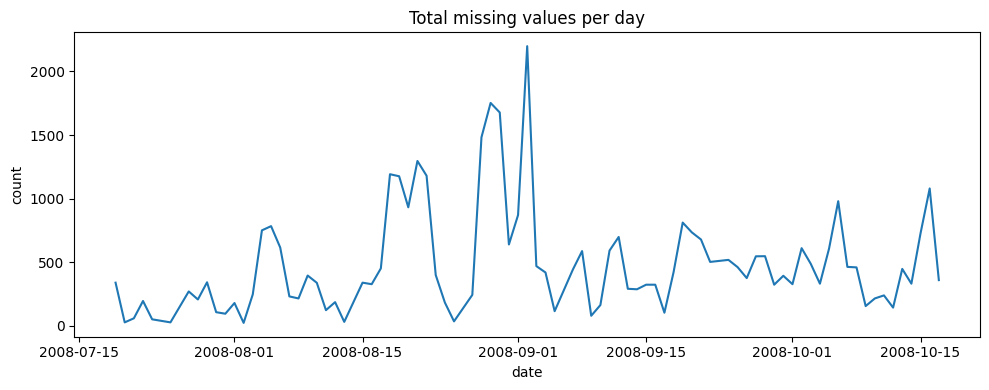

In [ ]:
# 센서만 분리
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
X = df[sensor_cols]

# 센서별 NaN 비율
na_ratio = X.isna().mean().sort_values(ascending=False)
display(na_ratio.head(20))

# 전체 평균 결측 비율
print("Mean NaN ratio (sensors only):", float(na_ratio.mean()))

# 시간대 결측 개수 (일 단위)
daily_missing = df.assign(date=df["timestamp"].dt.date).groupby("date")[sensor_cols].apply(lambda x: x.isna().sum().sum())
daily_missing = daily_missing.sort_index()

plt.figure(figsize=(10,4))
plt.plot(daily_missing.index, daily_missing.values)
plt.title("Total missing values per day")
plt.xlabel("date"); plt.ylabel("count")
plt.tight_layout(); plt.show()

### Core 2) 상수형/저분산 센서 탐색
- 분산≈0 센서 리스트업
- 기준은 경험적으로 `var <= 1e-6` (상황에 맞게 조정)
- 변별력이 없는 센서를 제거하여 잡음을 줄이는 근거 마련
-  변수와 데이터 구조를 줄여 모델 학습 효율 확보

In [ ]:
var_series = X.var(numeric_only=True)
low_var = var_series[var_series <= 1e-6].sort_values()
print("Low-variance sensors (<=1e-6):", len(low_var))
display(low_var.head(30))

Low-variance sensors (<=1e-6): 127


sensor_006    0.0
sensor_459    0.0
sensor_452    0.0
sensor_451    0.0
sensor_450    0.0
sensor_423    0.0
sensor_415    0.0
sensor_405    0.0
sensor_404    0.0
sensor_403    0.0
sensor_402    0.0
sensor_401    0.0
sensor_400    0.0
sensor_399    0.0
sensor_398    0.0
sensor_397    0.0
sensor_396    0.0
sensor_395    0.0
sensor_382    0.0
sensor_381    0.0
sensor_380    0.0
sensor_379    0.0
sensor_376    0.0
sensor_375    0.0
sensor_374    0.0
sensor_373    0.0
sensor_372    0.0
sensor_371    0.0
sensor_462    0.0
sensor_370    0.0
dtype: float64

### Core 3) 다중공선성
- 상관계수 Heatmap: 전 컬럼은 과중하니 **무작위 60개 샘플링**으로 시각화
- VIF: 수치적으로 다중공선성 점검 (샘플 컬럼 30개)
- 변별력이 없는 센서를 제거하여 잡음을 줄이는 근거 마련
-  변수와 데이터 구조를 줄여 모델 학습 효율 확보

### 전체 센서 다중공선성 요약 
- 센서 간 단순 선형 관계 ; 쌍별 확인 

In [ ]:

# 전체 상관계수 행렬 계산 (메모리 커서 시각화는 비효율적)
corr_all = X.corr()

# 상관계수 절댓값이 큰 경우(예: |r| > 0.95) 카운트
high_corr_pairs = ((corr_all.abs() > 0.95) & (corr_all.abs() < 1.0)).sum().sum() // 2

print("전체 센서 수:", len(sensor_cols))
print("전체 센서 조합 개수:", len(sensor_cols)*(len(sensor_cols)-1)//2)
print(f"|r| > 0.95 강한 상관 관계 센서쌍 개수: {high_corr_pairs}")

# 센서별 평균 상관계수 (자기 자신 제외)
mean_corr_per_sensor = corr_all.apply(lambda row: row.drop(row.name).abs().mean(), axis=1)
print("\n센서별 평균 상관계수 요약:")
print(mean_corr_per_sensor.describe())

전체 센서 수: 590
전체 센서 조합 개수: 173755
|r| > 0.95 강한 상관 관계 센서쌍 개수: 312

센서별 평균 상관계수 요약:
count    474.000000
mean       0.045422
std        0.017092
min        0.020735
25%        0.032573
50%        0.041107
75%        0.054480
max        0.092870
dtype: float64


### 정식 다중공선성 검증 

- 각 센서가 다른 모든 변수로 얼마나 설명 가능한지를 수치화
 - VIF > 10 : 심각한 다중공선성 의심
- 상관계수보다 더 정밀한 지표

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_vif_all = X.fillna(X.median())
X_vif_const = sm.add_constant(X_vif_all)

vif_list = []
for i, col in enumerate(X_vif_const.columns):
    if col == "const":
        continue
    vif_value = variance_inflation_factor(X_vif_const.values, i)
    vif_list.append((col, vif_value))

vif_df_all = pd.DataFrame(vif_list, columns=["feature","VIF"]).sort_values("VIF", ascending=False)
vif_df_all.head()

import pandas as pd
import numpy as np

# VIF = inf 센서
inf_df = vif_df_all[vif_df_all["VIF"] == np.inf].copy()
inf_df["VIF"] = "inf"   # 보기 좋게 문자열 표시
print("🔎 VIF = inf 센서 전체")
display(inf_df)

# VIF > 10 센서 전체
high_vif_df = vif_df_all[(vif_df_all["VIF"] != np.inf) & (vif_df_all["VIF"] > 10)].copy()
print(f"\n🔎 VIF > 10 센서 전체 (총 {len(high_vif_df)}개)")
display(high_vif_df)

/Users/mealkuo/Desktop/capstone02_project/capstone02/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mealkuo/Desktop/capstone02_project/capstone02/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/mealkuo/Desktop/capstone02_project/capstone02/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


🔎 VIF = inf 센서 전체


,feature,VIF
209,sensor_210,inf
206,sensor_207,inf
478,sensor_479,inf
74,sensor_075,inf
342,sensor_343,inf
347,sensor_348,inf



🔎 VIF > 10 센서 전체 (총 386개)


,feature,VIF
34,sensor_035,2.657993e+09
36,sensor_037,2.657958e+09
275,sensor_276,7.622463e+07
140,sensor_141,7.533128e+07
174,sensor_175,5.788456e+06
...,...,...
278,sensor_279,1.139023e+01
439,sensor_440,1.136533e+01
555,sensor_556,1.102377e+01
472,sensor_473,1.087013e+01


### Core 4) 불량 vs 정상 분포 차이
- 그룹별(라벨) 평균/표준편차 비교
- 일부 센서에 대해 boxplot/KDE 대체로 histogram 비교
- 어떤 센서가 불량 탐지에 의미 있는지 도출

In [ ]:
gstats = df.groupby("label")[sensor_cols].agg(["mean","std"]).T
gstats.head(10)

label                     -1            1
sensor_001 mean  3014.947316  3007.526250
           std     72.461809    88.409688
sensor_002 mean  2495.906115  2495.059709
           std     81.033476    71.316362
sensor_003 mean  2200.554886  2200.441877
           std     29.391944    31.302444
sensor_004 mean  1399.290292  1355.781435
           std    447.984948   341.306204
sensor_005 mean     4.404698     1.303405
           std     58.338675     0.336390

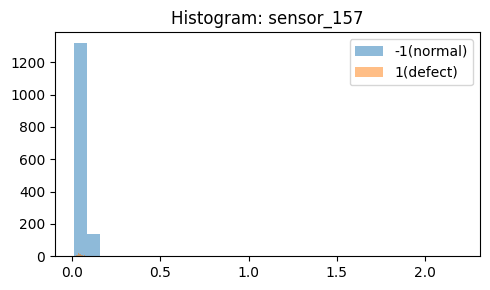

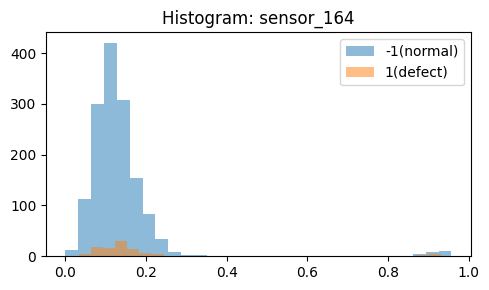

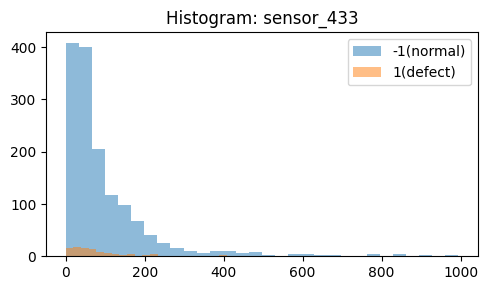

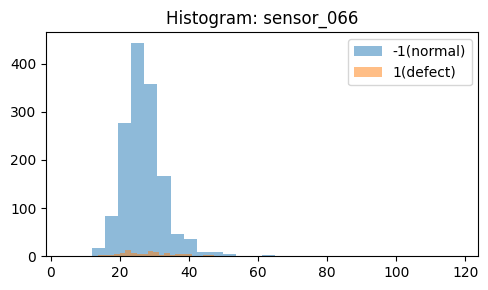

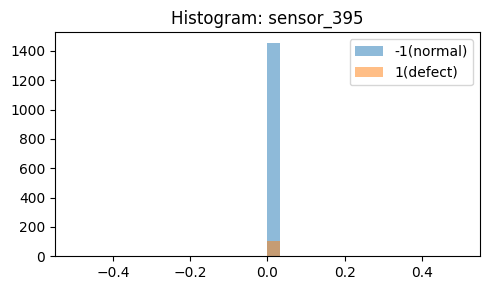

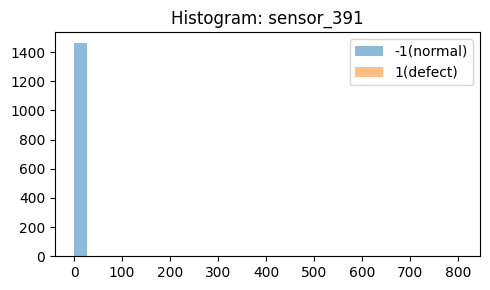

In [ ]:
# 대표 센서 6개를 뽑아 분포 비교
probe_cols = random.sample(sensor_cols, k=6)

for c in probe_cols:
    plt.figure(figsize=(5,3))
    n1, _, _ = plt.hist(df.loc[df["label"]==-1, c].dropna(), bins=30, alpha=0.5, label="-1(normal)")
    n2, _, _ = plt.hist(df.loc[df["label"]==1,  c].dropna(), bins=30, alpha=0.5, label="1(defect)")
    plt.title(f"Histogram: {c}")
    plt.legend()
    plt.tight_layout(); plt.show()

### Core 5) 피처 중요도 탐색
- Logistic 회귀(L2) 계수 절댓값 기준 상위
- RandomForest feature_importances_ 기준 상위
- 어떤 센서가 불량 탐지에 의미 있는지 도출
> 빠른 비교용으로 **결측 중앙값 대체 + 표준화** 간단 파이프라인 적용

logistic model

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
y = df["label"]
X_imp = SimpleImputer(strategy="median").fit_transform(X)
X_std = StandardScaler(with_mean=True, with_std=True).fit_transform(X_imp)

# Logistic (불균형 대응을 위해 class_weight='balanced' 제안)
logi = LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=None, solver="lbfgs")
logi.fit(X_std, y)

coef_abs = np.abs(logi.coef_[0])
logi_top_idx = np.argsort(-coef_abs)[:20]
logi_top = pd.DataFrame({
    "feature": np.array(sensor_cols)[logi_top_idx],
    "abs_coef": coef_abs[logi_top_idx]
}).reset_index(drop=True)
display(logi_top)

,feature,abs_coef
0,sensor_057,2.841166
1,sensor_060,1.955770
2,sensor_426,1.643923
3,sensor_133,1.639000
4,sensor_217,1.469405
5,sensor_389,1.350162
6,sensor_416,1.343529
7,sensor_334,1.318784
8,sensor_366,1.316202
9,sensor_062,1.300815


RandomForest model

In [ ]:
# RandomForest (기본 파라미터, 빠른 스캔용)
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
rf.fit(X_imp, y)

rf_imp = rf.feature_importances_
rf_top_idx = np.argsort(-rf_imp)[:20]
rf_top = pd.DataFrame({
    "feature": np.array(sensor_cols)[rf_top_idx],
    "importance": rf_imp[rf_top_idx]
}).reset_index(drop=True)
display(rf_top)

,feature,importance
0,sensor_060,0.016916
1,sensor_034,0.011018
2,sensor_104,0.009279
3,sensor_478,0.009135
4,sensor_248,0.008820
5,sensor_131,0.008015
6,sensor_130,0.007415
7,sensor_520,0.007368
8,sensor_511,0.006525
9,sensor_206,0.006347


### Core 6) 차원 축소 시각화
- PCA 2D scatter
- t-SNE 2D (시간 소요 → 샘플 800개만 랜덤 서브샘플)
- 센서 데이터 패턴에서 정상/불량 분리가 되는지 눈으로 확인

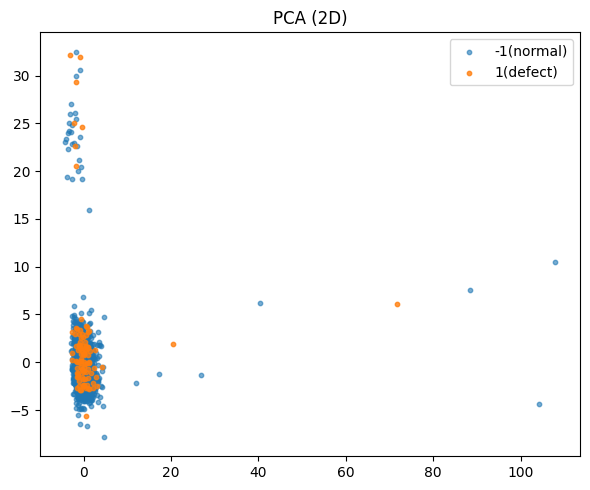

Explained variance ratio (2 comps): 0.0920040256603662


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[y==-1,0], X_pca[y==-1,1], s=10, alpha=0.6, label="-1(normal)")
plt.scatter(X_pca[y==1, 0], X_pca[y==1, 1], s=10, alpha=0.8, label="1(defect)")
plt.title("PCA (2D)")
plt.legend(); plt.tight_layout(); plt.show()

print("Explained variance ratio (2 comps):", pca.explained_variance_ratio_.sum())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.000s...
[t-SNE] Computed neighbors for 800 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 5.720119
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.848663
[t-SNE] KL divergence after 1000 iterations: 1.567436


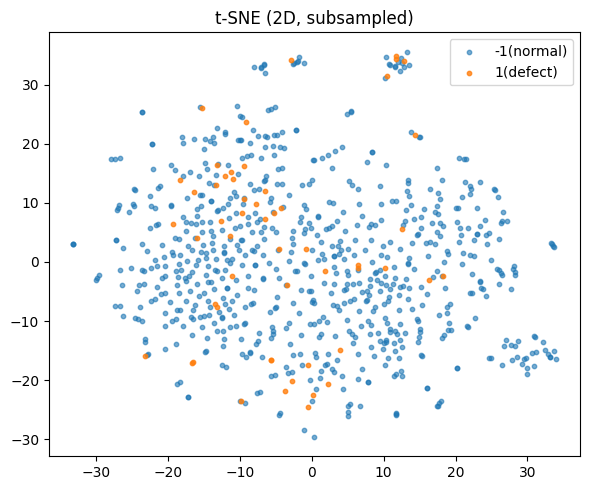

In [ ]:
from sklearn.manifold import TSNE

# 서브샘플 (최대 800)
sample_idx = np.random.RandomState(42).choice(len(X_std), size=min(800, len(X_std)), replace=False)
X_sub = X_std[sample_idx]
y_sub = y.values[sample_idx]

tsne = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=30,
    random_state=42,
    max_iter=1000,   
    verbose=1
)
X_tsne = tsne.fit_transform(X_sub)

plt.figure(figsize=(6,5))
plt.scatter(X_tsne[y_sub==-1,0], X_tsne[y_sub==-1,1], s=10, alpha=0.6, label="-1(normal)")
plt.scatter(X_tsne[y_sub==1, 0], X_tsne[y_sub==1,1], s=10, alpha=0.8, label="1(defect)")
plt.title("t-SNE (2D, subsampled)")
plt.legend(); plt.tight_layout(); plt.show()

### Core 7) 클래스 불균형 확인
- 라벨 카운트, 비율
- Stratified split 필요성 점검
-  변수와 데이터 구조를 줄여 모델 학습 효율 확보

In [ ]:
label_counts = y.value_counts().sort_index()
print("Counts:\n", label_counts)
print("Ratios:\n", (label_counts / label_counts.sum()).round(4))

Counts:
 label
-1    1463
 1     104
Name: count, dtype: int64
Ratios:
 label
-1    0.9336
 1    0.0664
Name: count, dtype: float64


### Core 8) 이상치 탐색
- 표준화된 Z-score 기준 |z|>4 (샘플 수, 센서별 평균 outlier 비율)
- IQR rule (Q1-1.5*IQR, Q3+1.5*IQR)를 센서별로 적용해 비율 확인 (상위 10)
- 센서 고장/노이즈 제거로 잘못된 탐지 줄여 비용 낭비 최소화
> 전수 계산이 무거울 수 있어 간단 통계만 구함

Z - score

In [ ]:
# Z-score 기반 (표준화 데이터 X_std 사용)
z = np.abs(X_std)
# 센서별 outlier 비율 (|z|>4)
outlier_ratio_per_sensor = (z > 4).mean(axis=0)
outlier_top = pd.Series(outlier_ratio_per_sensor, index=sensor_cols).sort_values(ascending=False)
print("Outlier ratio per sensor (|z|>4) - Top 10")
display(outlier_top.head(10))

Outlier ratio per sensor (|z|>4) - Top 10


sensor_577    0.040204
sensor_573    0.038290
sensor_575    0.034461
sensor_296    0.029355
sensor_161    0.029355
sensor_578    0.026165
sensor_036    0.021698
sensor_086    0.021059
sensor_160    0.021059
sensor_295    0.020421
dtype: float64

IQR 사분위

In [ ]:
# IQR 기반 (원본 센서값)
iqr_ratios = {}
for c in sensor_cols:
    s = X[c].dropna()
    if len(s) < 10:
        iqr_ratios[c] = np.nan
        continue
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        iqr_ratios[c] = 0.0
        continue
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    iqr_ratios[c] = ((s < lower) | (s > upper)).mean()

iqr_top = pd.Series(iqr_ratios).sort_values(ascending=False).head(10)
print("IQR-based outlier ratio - Top 10")
display(iqr_top)

IQR-based outlier ratio - Top 10


sensor_032    0.226198
sensor_041    0.213869
sensor_563    0.166151
sensor_130    0.152760
sensor_545    0.152716
sensor_313    0.149425
sensor_196    0.149072
sensor_178    0.146871
sensor_449    0.146871
sensor_468    0.139475
dtype: float64

In [ ]:
# 🔎 Z-score TOP20, IQR TOP20 교집합
z_top_features_20   = set(outlier_top.head(20).index)
iqr_top_features_20 = set(iqr_top.head(20).index)

intersection_features_20 = z_top_features_20.intersection(iqr_top_features_20)

print("Z-score & IQR 동시 상위 검출 센서 (TOP20 교집합):")
print(intersection_features_20 if intersection_features_20 else "⚠️ 없음")

Z-score & IQR 동시 상위 검출 센서 (TOP20 교집합):
⚠️ 없음


### Core 9: 데이터 샘플 품질 점검
- **중복 row 확인**: 동일한 센서 값이 반복되는 샘플 탐지
- **노이즈 row 탐지**: 특정 샘플에서 다수 센서 값이 동시에 튀는 경우 확인
- 샘플 전체에서 센서가 동시에 무너진 경우는 없으므로 row 단위 제거보단 센서 단위 전처리 필요

In [ ]:
# 노이즈 row 탐색: (센서 기준 이상치 수가 일정 threshold 이상인 row)
z = np.abs(X_std)
row_outlier_count = (z > 4).sum(axis=1)

threshold = int(0.2 * X.shape[1])  # 전체 센서의 20% 이상이 동시에 튄 경우 + 10% 이상으로 해도 없음
noisy_rows = pd.Series(row_outlier_count, index=df.index)
noisy_rows = noisy_rows[noisy_rows > threshold]

print(f"🔎 노이즈 row 개수 (센서 20% 이상 이상치): {len(noisy_rows)}")
display(noisy_rows.head())

🔎 노이즈 row 개수 (센서 20% 이상 이상치): 0


Series([], dtype: int64)

### Core 10: Scaling 영향도 확인
- **StandardScaler, MinMaxScaler, RobustScaler** 비교
- 특정 센서 분포 변화를 시각화

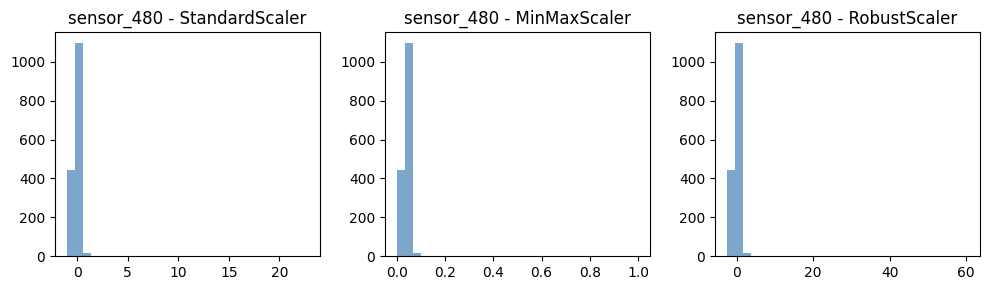

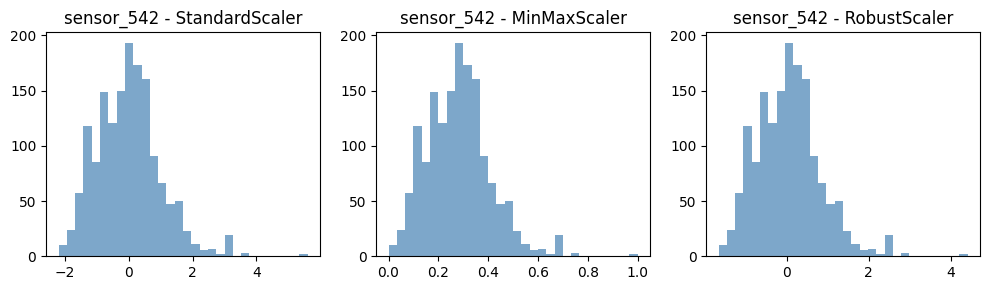

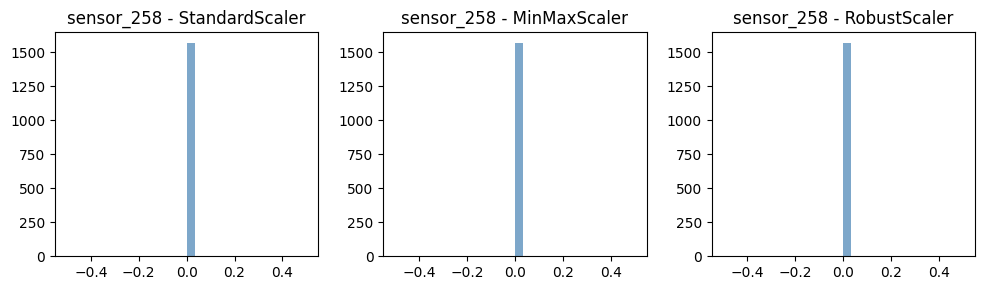

In [ ]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

probe_cols = random.sample(sensor_cols, k=3)  # 샘플 센서 3개만 시각화

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

for col in probe_cols:
    plt.figure(figsize=(10,3))
    for i, (name, scaler) in enumerate(scalers.items(), 1):
        scaled = scaler.fit_transform(X[[col]].fillna(X[col].median()))
        plt.subplot(1,3,i)
        plt.hist(scaled, bins=30, alpha=0.7, color="steelblue")
        plt.title(f"{col} - {name}")
    plt.tight_layout()
    plt.show()

### Core 11: SHAP 기반 피처 중요도 해석
- 목적: RandomForest로 학습한 모델에 대해 **불량(positive class=1)** 에 기여하는 센서의 영향도를 SHAP으로 해석
- 출력:
  1) 요약 플롯(`summary_plot`) – 전역적 중요 센서와 방향성
  2) 막대 플롯 – 평균 |SHAP| 상위 센서 Top-K (보고서용)
- 주의: 계산량 절약을 위해 샘플 400개만 사용(필요 시 `N_SAMPLES` 조절)

/Users/mealkuo/Desktop/capstone02_project/capstone02/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ StandardScaler 기반 Logistic ∩ RF (모두 중요): {'sensor_130', 'sensor_060'}
✅ RobustScaler 기반 Logistic ∩ RF (모두 중요): {'sensor_349', 'sensor_130', 'sensor_060', 'sensor_511', 'sensor_032', 'sensor_034'}


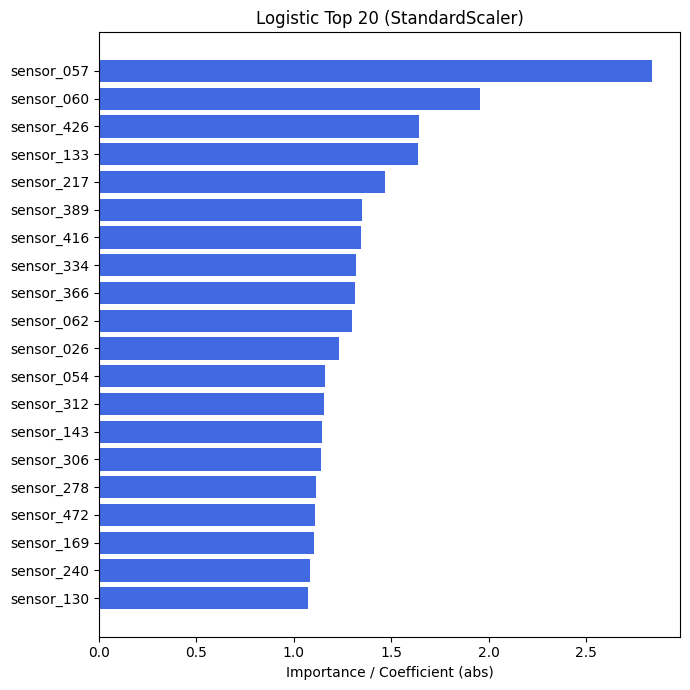

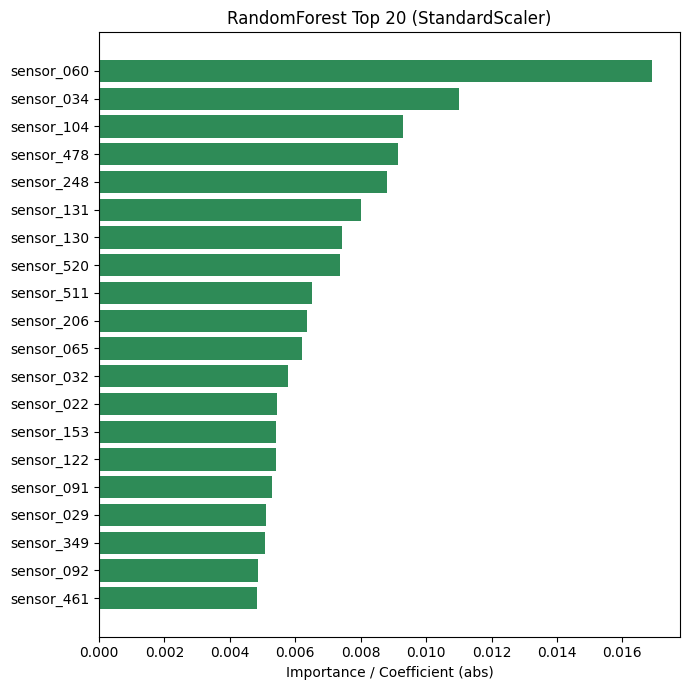

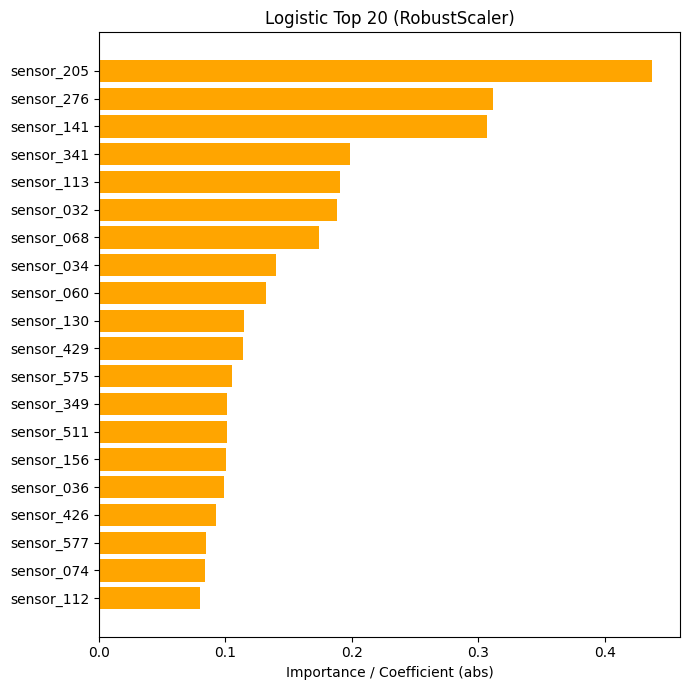

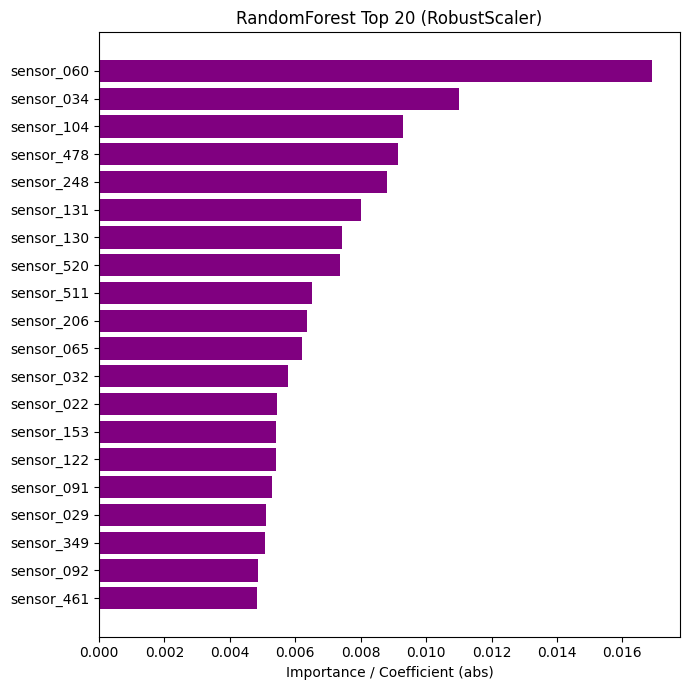

/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ipykernel_14544/3455387027.py:126: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ipykernel_14544/3455387027.py:126: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ipykernel_14544/3455387027.py:126: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ipykernel_14544/3455387027.py:126: UserWarning: Glyph 51665 (\N{HANGUL SYLLABLE JIB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ipykernel_14544/3455387027.py:126: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/5j/xncx4f310w93nzyd92xch9jh0000gn/T/ip

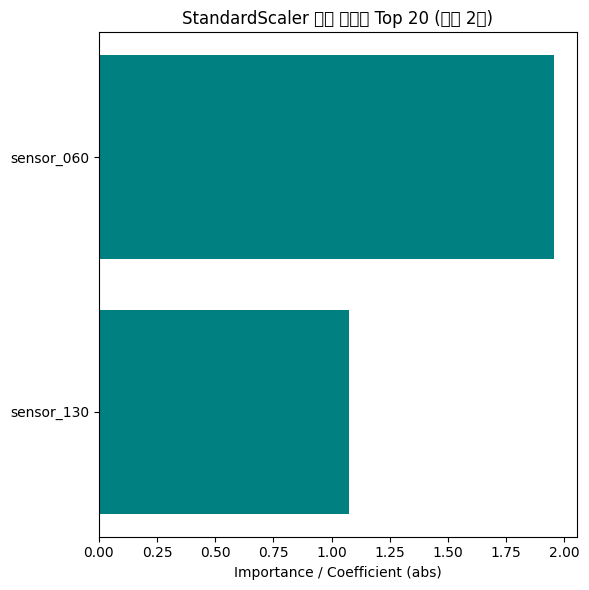

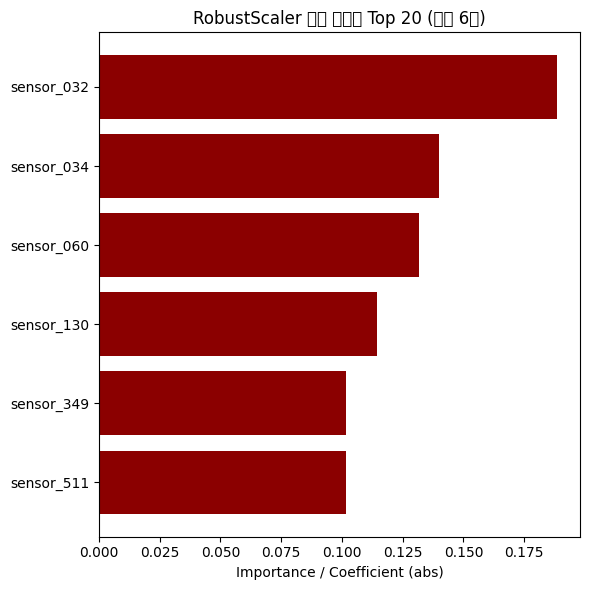

In [7]:
# ----- 0) 데이터 로드 -----
PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
EDA_CSV = PROJECT_ROOT / "data" / "secom_master_eda.csv"


df = pd.read_csv(EDA_CSV, parse_dates=["timestamp"])
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
X = df[sensor_cols]
y = df["label"]


# ----- 1) 결측치 대체 -----
from sklearn.impute import SimpleImputer


imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)


# ----- 2) StandardScaler 기반 Logistic & RF -----
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


scaler_std = StandardScaler()
X_std = scaler_std.fit_transform(X_imp)


logi_std = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs")
logi_std.fit(X_std, y)
coef_abs_std = np.abs(logi_std.coef_[0])
logi_top_idx_std = np.argsort(-coef_abs_std)[:20]
logi_top_std = pd.DataFrame({
    "feature": np.array(sensor_cols)[logi_top_idx_std],
    "score": coef_abs_std[logi_top_idx_std],
    "model": "Logistic_Standard"
})


rf_std = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
rf_std.fit(X_imp, y)
rf_imp_std = rf_std.feature_importances_
rf_top_idx_std = np.argsort(-rf_imp_std)[:20]
rf_top_std = pd.DataFrame({
    "feature": np.array(sensor_cols)[rf_top_idx_std],
    "score": rf_imp_std[rf_top_idx_std],
    "model": "RF_Standard"
})


# ----- 3) RobustScaler 기반 Logistic & RF -----
from sklearn.preprocessing import RobustScaler


scaler_rob = RobustScaler()
X_rob = scaler_rob.fit_transform(X_imp)


logi_rob = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs")
logi_rob.fit(X_rob, y)
coef_abs_rob = np.abs(logi_rob.coef_[0])
logi_top_idx_rob = np.argsort(-coef_abs_rob)[:20]
logi_top_rob = pd.DataFrame({
    "feature": np.array(sensor_cols)[logi_top_idx_rob],
    "score": coef_abs_rob[logi_top_idx_rob],
    "model": "Logistic_Robust"
})


rf_rob = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
rf_rob.fit(X_imp, y)
rf_imp_rob = rf_rob.feature_importances_
rf_top_idx_rob = np.argsort(-rf_imp_rob)[:20]
rf_top_rob = pd.DataFrame({
    "feature": np.array(sensor_cols)[rf_top_idx_rob],
    "score": rf_imp_rob[rf_top_idx_rob],
    "model": "RF_Robust"
})


# ----- 4) 교집합 분석 -----
set_logi_std = set(logi_top_std["feature"])
set_rf_std = set(rf_top_std["feature"])
set_logi_rob = set(logi_top_rob["feature"])
set_rf_rob = set(rf_top_rob["feature"])
common_std = set_logi_std & set_rf_std
common_rob = set_logi_rob & set_rf_rob


print("✅ StandardScaler 기반 Logistic ∩ RF (모두 중요):", common_std)
print("✅ RobustScaler 기반 Logistic ∩ RF (모두 중요):", common_rob)


# ----- 5) 막대 그래프 비교 (Top 20) -----
import matplotlib.pyplot as plt


def plot_barh(df, title, color):
    plt.figure(figsize=(7,7))
    plt.barh(df["feature"][::-1], df["score"][::-1], color=color)
    plt.title(title)
    plt.xlabel("Importance / Coefficient (abs)")
    plt.tight_layout()
    plt.show()


# StandardScaler 기반
plot_barh(logi_top_std, "Logistic Top 20 (StandardScaler)", "royalblue")
plot_barh(rf_top_std, "RandomForest Top 20 (StandardScaler)", "seagreen")


# RobustScaler 기반
plot_barh(logi_top_rob, "Logistic Top 20 (RobustScaler)", "orange")
plot_barh(rf_top_rob, "RandomForest Top 20 (RobustScaler)", "purple")


# ----- 6) 모델별 Top 20 교집합 시각화 -----
def plot_intersection_barh(df1, df2, title, color):
    inter = set(df1["feature"]) & set(df2["feature"])
    inter_df = df1[df1["feature"].isin(inter)]
    plt.figure(figsize=(6,6))
    plt.barh(inter_df["feature"][::-1], inter_df["score"][::-1], color=color)
    plt.title(title + f" (공통 {len(inter)}개)")
    plt.xlabel("Importance / Coefficient (abs)")
    plt.tight_layout()
    plt.show()


plot_intersection_barh(logi_top_std, rf_top_std, "StandardScaler 기반 교집합 Top 20", "teal")
plot_intersection_barh(logi_top_rob, rf_top_rob, "RobustScaler 기반 교집합 Top 20", "darkred")

/Users/mealkuo/Desktop/capstone02_project/capstone02/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic ∩ RF (모두 중요): {'sensor_125', 'sensor_130', 'sensor_060', 'sensor_066', 'sensor_206'}
Logistic Top 30: 30, RF Top 30: 30, 교집합: 5
✅ RobustScaler 기반 Logistic ∩ RF (모두 중요): {'sensor_349', 'sensor_130', 'sensor_060', 'sensor_511', 'sensor_104', 'sensor_032', 'sensor_034'}
Logistic_Robust Top 30: 30, RF_Robust Top 30: 30, 교집합: 7


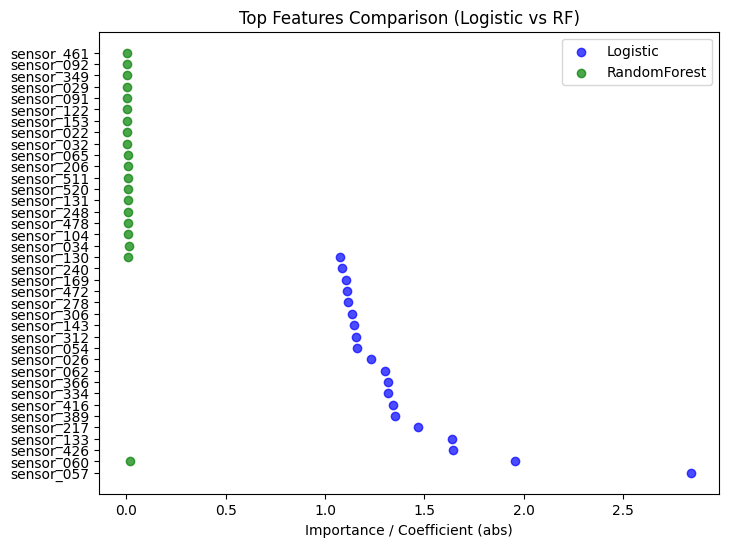

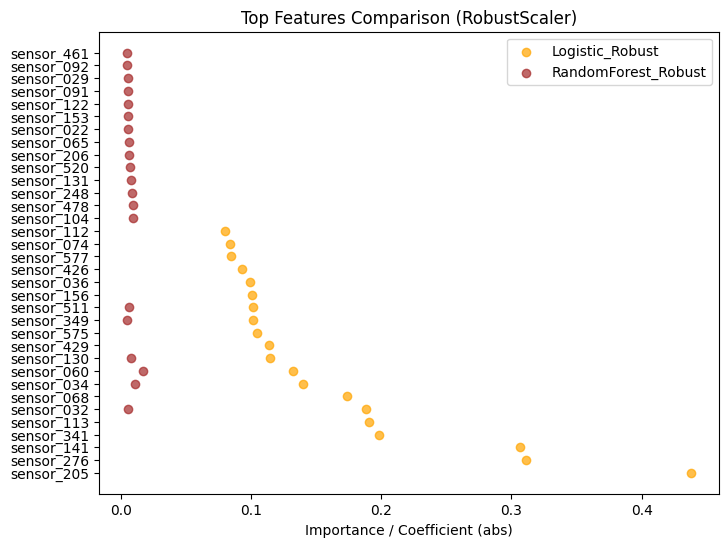

In [17]:
# ----- 0) 데이터 로드 -----
PROJECT_ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
EDA_CSV = PROJECT_ROOT / "data" / "secom_master_eda.csv"


df = pd.read_csv(EDA_CSV, parse_dates=["timestamp"])
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
X = df[sensor_cols]
y = df["label"]


# ----- 1) 결측치 대체 및 표준화 -----
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler


imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)


# StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)


# RobustScaler
scaler_rob = RobustScaler()
X_rob = scaler_rob.fit_transform(X_imp)


# ----- 2) Logistic Regression (선형) -----
from sklearn.linear_model import LogisticRegression


logi = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs")
logi.fit(X_std, y)
coef_abs = np.abs(logi.coef_[0])
logi_top_idx = np.argsort(-coef_abs)[:30]
logi_top = pd.DataFrame({
    "feature": np.array(sensor_cols)[logi_top_idx],
    "score": coef_abs[logi_top_idx],
    "model": "Logistic"
})


# RobustScaler 기반 Logistic
logi_rob = LogisticRegression(max_iter=300, class_weight="balanced", solver="lbfgs")
logi_rob.fit(X_rob, y)
coef_abs_rob = np.abs(logi_rob.coef_[0])
logi_top_idx_rob = np.argsort(-coef_abs_rob)[:30]
logi_top_rob = pd.DataFrame({
    "feature": np.array(sensor_cols)[logi_top_idx_rob],
    "score": coef_abs_rob[logi_top_idx_rob],
    "model": "Logistic_Robust"
})


# ----- 3) RandomForest (비선형) -----
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
rf.fit(X_imp, y)
rf_imp = rf.feature_importances_
rf_top_idx = np.argsort(-rf_imp)[:30]
rf_top = pd.DataFrame({
    "feature": np.array(sensor_cols)[rf_top_idx],
    "score": rf_imp[rf_top_idx],
    "model": "RandomForest"
})


# RobustScaler 기반 RandomForest
rf_rob = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1)
rf_rob.fit(X_rob, y)
rf_imp_rob = rf_rob.feature_importances_
rf_top_idx_rob = np.argsort(-rf_imp_rob)[:30]
rf_top_rob = pd.DataFrame({
    "feature": np.array(sensor_cols)[rf_top_idx_rob],
    "score": rf_imp_rob[rf_top_idx_rob],
    "model": "RandomForest_Robust"
})


# ----- 4) 교집합 분석 -----
set_logi = set(logi_top["feature"])
set_rf = set(rf_top["feature"])
common_features = set_logi & set_rf


set_logi_rob = set(logi_top_rob["feature"])
set_rf_rob = set(rf_top_rob["feature"])
common_features_rob = set_logi_rob & set_rf_rob


print("✅ Logistic ∩ RF (모두 중요):", common_features)
print(f"Logistic Top 30: {len(set_logi)}, RF Top 30: {len(set_rf)}, 교집합: {len(common_features)}")


print("✅ RobustScaler 기반 Logistic ∩ RF (모두 중요):", common_features_rob)
print(f"Logistic_Robust Top 30: {len(set_logi_rob)}, RF_Robust Top 30: {len(set_rf_rob)}, 교집합: {len(common_features_rob)}")


# ----- 5) 시각화 -----
import matplotlib.pyplot as plt


top_all = pd.concat([logi_top, rf_top])
plt.figure(figsize=(8, 6))
for model, color in zip(["Logistic", "RandomForest"], ["blue", "green"]):
    subset = top_all[top_all["model"] == model].head(20)
    plt.scatter(subset["score"], subset["feature"], label=model, alpha=0.7, color=color)
plt.legend()
plt.title("Top Features Comparison (Logistic vs RF)")
plt.xlabel("Importance / Coefficient (abs)")
plt.show()


# RobustScaler 기반 scatter
top_all_rob = pd.concat([logi_top_rob, rf_top_rob])
plt.figure(figsize=(8, 6))
for model, color in zip(["Logistic_Robust", "RandomForest_Robust"], ["orange", "brown"]):
    subset = top_all_rob[top_all_rob["model"] == model].head(20)
    plt.scatter(subset["score"], subset["feature"], label=model, alpha=0.7, color=color)
plt.legend()
plt.title("Top Features Comparison (RobustScaler)")
plt.xlabel("Importance / Coefficient (abs)")
plt.show()

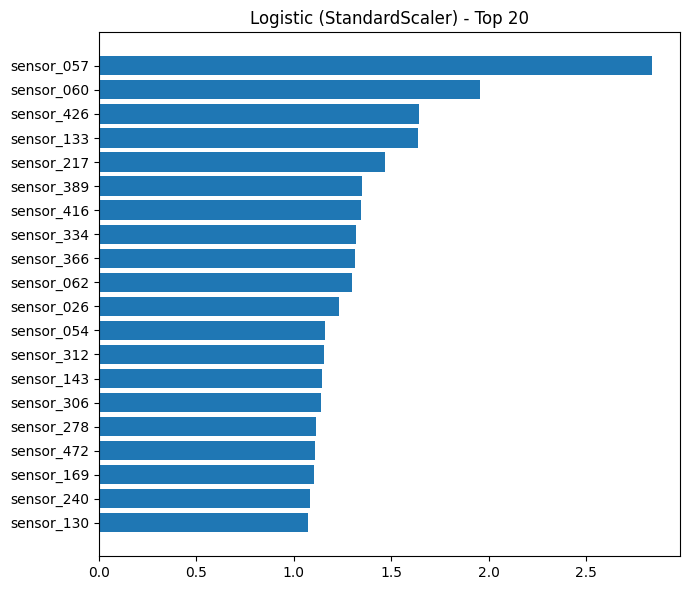

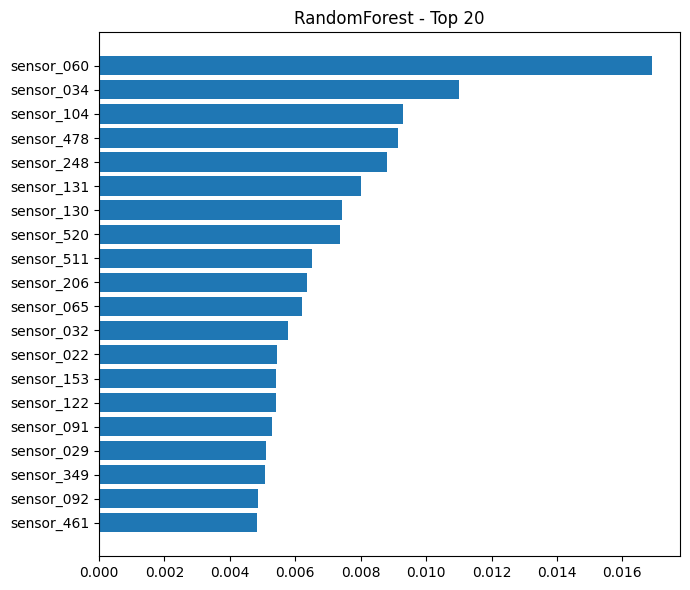

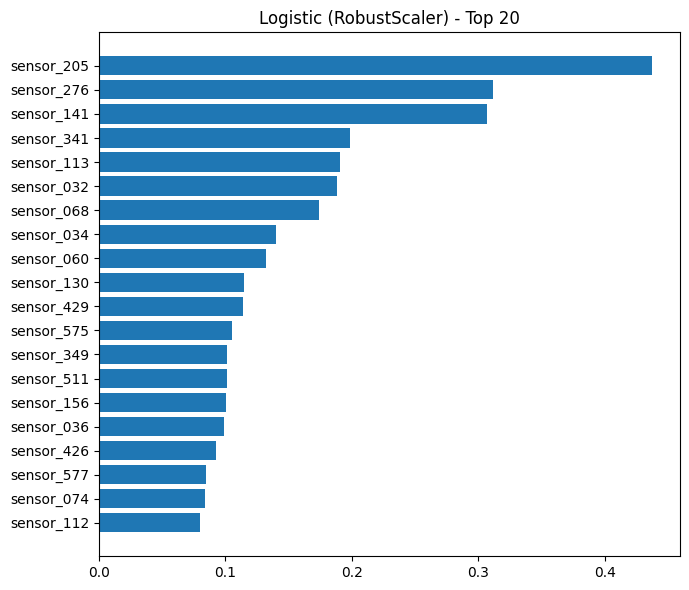

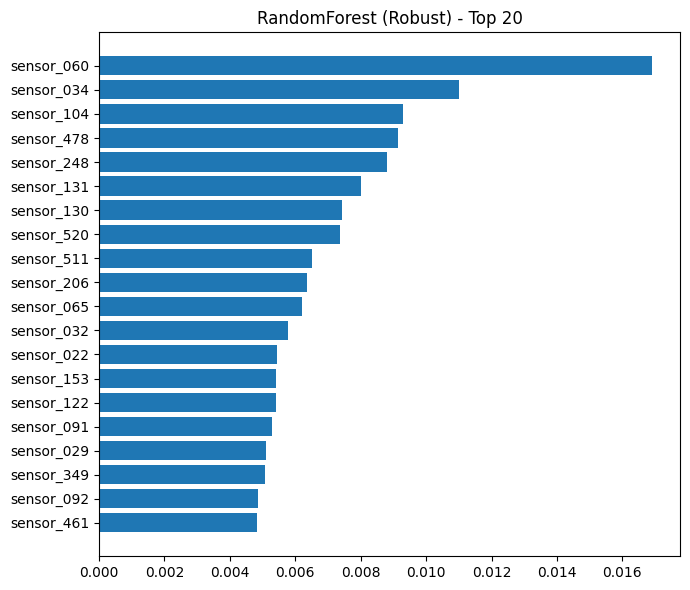

In [18]:
def barh_top(df, title):
    d = df.sort_values("score").tail(20)
    plt.figure(figsize=(7,6))
    plt.barh(d["feature"], d["score"])
    plt.title(title); plt.tight_layout(); plt.show()

barh_top(logi_top,     "Logistic (StandardScaler) - Top 20")
barh_top(rf_top,       "RandomForest - Top 20")
barh_top(logi_top_rob, "Logistic (RobustScaler) - Top 20")
barh_top(rf_top_rob,   "RandomForest (Robust) - Top 20")

In [19]:
# --- 교집합 분석 및 출력 ---
# 1. StandardScaler 기반 Top 20 교집합
std_logi_set = set(logi_top.sort_values("score").tail(20)["feature"])
std_rf_set   = set(rf_top.sort_values("score").tail(20)["feature"])
std_intersection = std_logi_set & std_rf_set
print("[StandardScaler] Logistic ∩ RF Top 20 교집합:")
print(std_intersection if std_intersection else "⚠️ 없음")

# 2. RobustScaler 기반 Top 20 교집합
rob_logi_set = set(logi_top_rob.sort_values("score").tail(20)["feature"])
rob_rf_set   = set(rf_top_rob.sort_values("score").tail(20)["feature"])
rob_intersection = rob_logi_set & rob_rf_set
print("[RobustScaler] Logistic ∩ RF Top 20 교집합:")
print(rob_intersection if rob_intersection else "⚠️ 없음")

# 3. Standard vs Robust Top 20 교집합 (Logistic+RF 합집합 기준)
std_all_set = std_logi_set | std_rf_set
rob_all_set = rob_logi_set | rob_rf_set
std_rob_intersection = std_all_set & rob_all_set
print("[Standard vs Robust] Top 20 합집합 교집합:")
print(std_rob_intersection if std_rob_intersection else "⚠️ 없음")

[StandardScaler] Logistic ∩ RF Top 20 교집합:
{'sensor_130', 'sensor_060'}
[RobustScaler] Logistic ∩ RF Top 20 교집합:
{'sensor_349', 'sensor_130', 'sensor_060', 'sensor_511', 'sensor_032', 'sensor_034'}
[Standard vs Robust] Top 20 합집합 교집합:
{'sensor_511', 'sensor_461', 'sensor_520', 'sensor_065', 'sensor_131', 'sensor_478', 'sensor_034', 'sensor_122', 'sensor_248', 'sensor_426', 'sensor_349', 'sensor_060', 'sensor_153', 'sensor_206', 'sensor_130', 'sensor_091', 'sensor_029', 'sensor_104', 'sensor_022', 'sensor_092', 'sensor_032'}


# 빅데분 정리